## Project Overview

### Business Understanding

This project is about sparkify music streaming service which is a hypothetical concept of music streaming platform, user's can listen music on their devices, it is similar kind of service like spotify, pandora etc. we will be analyzing it's data which is pretty interesting. The data is about user's interaction with their service, like user's data contains their gender, location, which songs they listen to, which are the pages they visit, did they upgrade or downgrade & so on, again music data like songs we don't have much data related to songs, again we have log informatin of the user like, when did a user registered with the serive, sessions, is the errors they encounter then what are those errors, timestamp of each action, when did a perticular song was played and all, like this we have a lot explore from this data in this project

Our main goal of the project is to find the user's who left the service or the user who is going to churn. For that we have all the information almost or we we don't we have to find that in this project pretty much exciting han? So, without the further go let's dive into it & start working on the data. To make our path easy we have set small milestones as follows which helps us understand the high level of the process.


* Business Understanding 
* Data Understanding
* Data Preprocessing
* Feature Engineering
* Data preparation for Modeling
* Modeling
* Evaluating Model
* Displaying Result
* Justification & Conclusion

In [ ]:
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
#!tar xf spark-3.1.2-bin-hadoop3.2.tgz
#!pip install -q findspark

In [ ]:
#import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
#from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import asc,desc,udf, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType,ArrayType, StructField, StructType

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline


import datetime
import time
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


## Data Understanding

In [ ]:
# spark = SparkSession \
#     .builder \
#     .appName("my_Wrangling_Data") \
#     .getOrCreate()

In [ ]:
path = "file:///E:\Projects\Spark\DATA\mini_sparkify_event_data.json"  # Path where data resides
#path = '/content/drive/MyDrive/mini_sparkify_event_data.json'
df = spark.read.json(path)  # reading the data

In [ ]:
df.show(5) # top 5 rows

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [ ]:
pd_df = pd.DataFrame(df.collect(),columns=df.columns) # let's have a look from pandas
pd_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


In [ ]:
df.printSchema() # Schema of the dataset

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
df.count() # Number of rows

286500

In [ ]:
len(df.columns) # Number of Columns

18

In [ ]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [ ]:
df.describe("userId").show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910527|
|    min|                  |
|    max|                99|
+-------+------------------+



#### Number of Empty Values

These are empty userId values and they are many.

In [ ]:
df.where(df["userId"] == "").select("userId").count()

8346

#### Number of Missing values

In [ ]:
pd_df.isna().sum()

artist           58392
auth             0    
firstName        8346 
gender           8346 
itemInSession    0    
lastName         8346 
length           58392
level            0    
location         8346 
method           0    
page             0    
registration     8346 
sessionId        0    
song             58392
status           0    
ts               0    
userAgent        8346 
userId           0    
dtype: int64

#### Number of unique page request by the user present in the data

In [ ]:
df.select("page").dropDuplicates().sort("page").show(23)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



#### Timestamp & dates

In [ ]:
df.select("registration").show(5) #Timestamp

+-------------+
| registration|
+-------------+
|1538173362000|
|1538331630000|
|1538173362000|
|1538331630000|
|1538173362000|
+-------------+
only showing top 5 rows



In [ ]:
# converting the timestamps into datetime format and adding them to the dataframe
df = df.withColumn('registrationDate', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('date_ts', (df['ts'] / 1000).cast(TimestampType()))
df.select("date_ts").show(5)

+-------------------+
|            date_ts|
+-------------------+
|2018-10-01 00:01:57|
|2018-10-01 00:03:00|
|2018-10-01 00:06:34|
|2018-10-01 00:06:56|
|2018-10-01 00:11:16|
+-------------------+
only showing top 5 rows



Now we have clear formatting for time. we can explore things like our dataset date ranges between and many more

In [ ]:
print("First Date in the dataset:".format(df.select("date_ts").sort("date_ts").show(1)))  # Data From (date)
print("Last Date in the dataset:".format(df.select("date_ts").sort("date_ts",ascending= False).show(1)))  # Data to (date)

+-------------------+
|            date_ts|
+-------------------+
|2018-10-01 00:01:57|
+-------------------+
only showing top 1 row

First Date in the dataset:
+-------------------+
|            date_ts|
+-------------------+
|2018-12-03 01:11:16|
+-------------------+
only showing top 1 row

Last Date in the dataset:


We have two months of data from 1st october to 3rd december. it looks like 2months but we have a lot to explore

##### As we can see that our data set has 18 columns which represent specific information related to some entity, Now we can grab those entities and segregate our data into high level information. Like we can see in that there is information related to user, some columns related to songs & lastly other columns shows log information.

##### So, we can divide them as 1.User information 2.Songs information 3.User-log information

### 1.User Information

In [ ]:
user_info = df.select(["userId","firstName","lastName","gender","location","page","userAgent","registration","level"])
user_info.show(10)

+------+---------+--------+------+--------------------+---------------+--------------------+-------------+-----+
|userId|firstName|lastName|gender|            location|           page|           userAgent| registration|level|
+------+---------+--------+------+--------------------+---------------+--------------------+-------------+-----+
|    30|    Colin| Freeman|     M|     Bakersfield, CA|       NextSong|Mozilla/5.0 (Wind...|1538173362000| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|       NextSong|"Mozilla/5.0 (Win...|1538331630000| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|       NextSong|Mozilla/5.0 (Wind...|1538173362000| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|       NextSong|"Mozilla/5.0 (Win...|1538331630000| free|
|    30|    Colin| Freeman|     M|     Bakersfield, CA|       NextSong|Mozilla/5.0 (Wind...|1538173362000| paid|
|     9|    Micah|    Long|     M|Boston-Cambridge-...|       NextSong|"Mozilla/5.0 (Win...|1538

In [ ]:
user_info = user_info.dropna(how="any")  # let's drop NA values for now 
user_info = user_info[user_info.userId != ""] # this will make sure we don't have empty values

#### Number of unique users in the data

In [ ]:
user_info.select("userId").distinct().count()

225

#### Number of Paid & free Users

In [ ]:
user_info.select("userId","gender").distinct().groupby("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



Remember we have seen some empty values in the userId column. We can check more information with this as well.

In [ ]:
df.where(df.userId == "").select(['userId', 'firstName', 'lastName', 'gender', 'location', 'registration', 'userAgent', 'level', 'Date_ts', 'page', 'auth',]).show(10)

+------+---------+--------+------+--------+------------+---------+-----+-------------------+-----+----------+
|userId|firstName|lastName|gender|location|registration|userAgent|level|            Date_ts| page|      auth|
+------+---------+--------+------+--------+------------+---------+-----+-------------------+-----+----------+
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:02:25| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:03:27| Help|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:04:01| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:04:02|Login|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:17:58| Home|Logged Out|
|      |     null|    null|  null|    null|        null|     null| free|2018-10-01 01:17:59|Login|Logged Out|
|      |  

Auth column represent if a user has logged out or logged in, from this table it cames to know that user who logged out has no information it is shown by empty values. further we can check auth column when there are empty values.

In [ ]:
df.where(df["userId"] == "").groupby("auth").count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



There we go, when user logged out or as guest we don't have user information.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


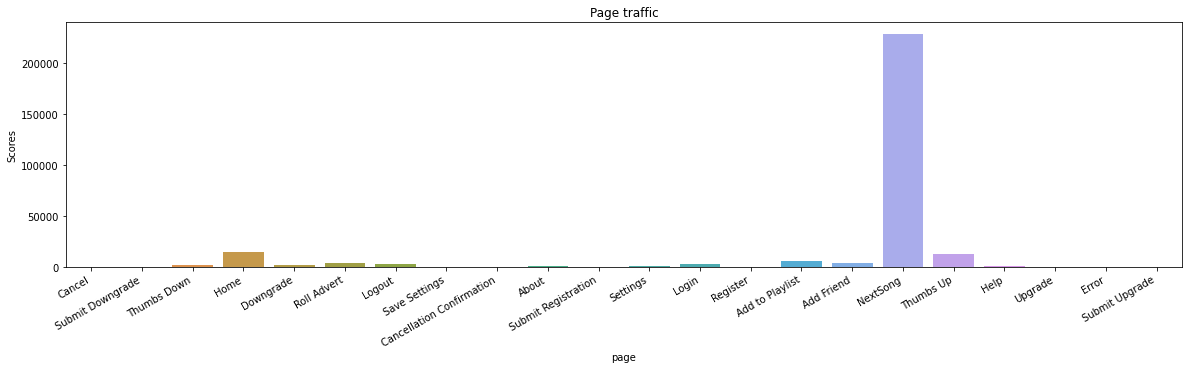

In [ ]:
# let's find out on which page user spent most time

pages = df.groupby('page').count().toPandas()
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(pages['page'], pages['count'])
ax.set_ylabel('Scores')
ax.set_title('Page traffic')
fig.autofmt_xdate();

Looks like user spent most their time on nextsong page & yeah it's obivious followed by home & like

#### Who cancels the service more often, paid users or free users?

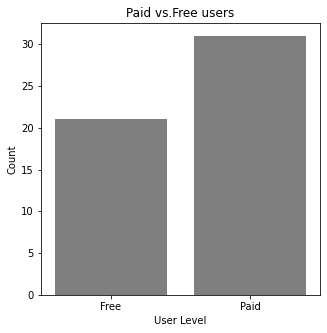

In [ ]:
# Plotting a bar plot to show differense between Paid & Free users
fig, ax = plt.subplots(figsize=(5, 5))

level_df = user_info.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Paid vs.Free users')
sns.barplot(data = level_df, x = 'level', y = 'count', color = sns.color_palette()[7])

ax.set(xticklabels=['Free', 'Paid'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level');

### 2. Songs Information

In [ ]:
song_info = df.select(['artist','song','length','page'])
song_info = song_info.dropna(how='all')
song_info.show()
print("number of entries:",song_info.count())

+--------------------+--------------------+---------+---------------+
|              artist|                song|   length|           page|
+--------------------+--------------------+---------+---------------+
|      Martha Tilston|           Rockpools|277.89016|       NextSong|
|    Five Iron Frenzy|              Canada|236.09424|       NextSong|
|        Adam Lambert|   Time For Miracles| 282.8273|       NextSong|
|              Enigma|Knocking On Forbi...|262.71302|       NextSong|
|           Daft Punk|Harder Better Fas...|223.60771|       NextSong|
|The All-American ...|      Don't Leave Me|208.29995|       NextSong|
|The Velvet Underg...|         Run Run Run|260.46649|       NextSong|
|        Starflyer 59|Passengers (Old A...|185.44281|       NextSong|
|                null|                null|     null|Add to Playlist|
|            Frumpies|          Fuck Kitty|134.47791|       NextSong|
|        Britt Nicole|   Walk On The Water| 229.8771|       NextSong|
|                nul

In [ ]:
song_info.groupby("artist","song","page").count().sort("count",ascending=False).show()

+--------------------+--------------------+---------------+-----+
|              artist|                song|           page|count|
+--------------------+--------------------+---------------+-----+
|                null|                null|           Home|14457|
|                null|                null|      Thumbs Up|12551|
|                null|                null|Add to Playlist| 6526|
|                null|                null|     Add Friend| 4277|
|                null|                null|    Roll Advert| 3933|
|                null|                null|          Login| 3241|
|                null|                null|         Logout| 3226|
|                null|                null|    Thumbs Down| 2546|
|                null|                null|      Downgrade| 2055|
|                null|                null|           Help| 1726|
|                null|                null|       Settings| 1514|
|       Dwight Yoakam|      You're The One|       NextSong| 1122|
|         

I think these two users who logged out or came as a guest and interesting thing is that they access multiple pages tried few features of the platform as well. they are top at giving thumbs to songs. let's try after removing all null values

In [ ]:
song_info = song_info.dropna(how='any')
song_info.groupby("artist","song","page").count().sort("count",ascending=False).show()

+--------------------+--------------------+--------+-----+
|              artist|                song|    page|count|
+--------------------+--------------------+--------+-----+
|       Dwight Yoakam|      You're The One|NextSong| 1122|
|            BjÃÂ¶rk|                Undo|NextSong| 1026|
|       Kings Of Leon|             Revelry|NextSong|  854|
|            Harmonia|       Sehr kosmisch|NextSong|  728|
|Barry Tuckwell/Ac...|Horn Concerto No....|NextSong|  641|
|Florence + The Ma...|Dog Days Are Over...|NextSong|  574|
|         OneRepublic|             Secrets|NextSong|  463|
|       Kings Of Leon|        Use Somebody|NextSong|  459|
|    Five Iron Frenzy|              Canada|NextSong|  434|
|            Tub Ring|             Invalid|NextSong|  424|
|           Sam Cooke|    Ain't Misbehavin|NextSong|  409|
|     Alliance Ethnik|       ReprÃÂ©sente|NextSong|  393|
|     Alliance Ethnik|SinceritÃÂ© Et J...|NextSong|  384|
|       Lonnie Gordon|Catch You Baby (S...|NextSong|  37

In [ ]:
song_info.where(song_info.page == "NextSong").groupBy('page').count().show() # number of songs listened

+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



In [ ]:
print("Number of different artists is {}".format(df.where(df.artist.isNotNull()).select('artist').dropDuplicates().count()))
print("Number of different song names is {}".format(df.where(df.song.isNotNull()).select('song').dropDuplicates().count()))
print("Number of songs in dataset is {}".format(df.select(['artist','song','length']).dropDuplicates().count()))

Number of different artists is 17655
Number of different song names is 58480
Number of songs in dataset is 65966


#### Hour's of music listened by the user

In [ ]:
get_hours = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn("hours", get_hours(df.ts))

songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hours).count().orderBy(df.hours.cast("float"))
songs_in_hour.show(5)
songs_in_hour_df = songs_in_hour.toPandas()

+-----+-----+
|hours|count|
+-----+-----+
|    0| 9062|
|    1| 8388|
|    2| 8336|
|    3| 8355|
|    4| 8147|
+-----+-----+
only showing top 5 rows



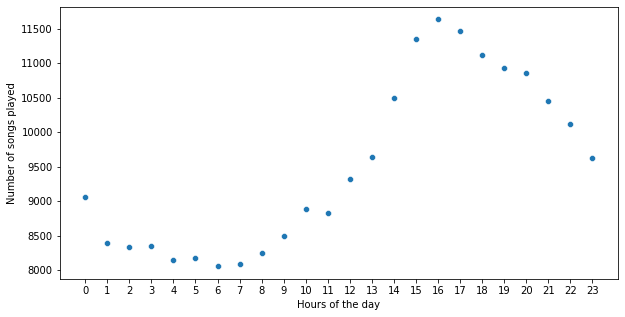

In [ ]:
fig,ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=songs_in_hour_df,x = "hours",y="count");
ax.set_xlabel("Hours of the day")
ax.set_ylabel("Number of songs played");


This is pretty interesting, Most users spends their time at the night. We can see trending graph from afternoon till midnight it's moving in upwards direction. People who spends less time using the service is from morning.

### 3. Log Information

In [ ]:
log_info = df.select(['Date_ts', 'page', 'auth', 'sessionId', 'itemInSession', 'method', 'status'])
log_info.show()

+-------------------+---------------+---------+---------+-------------+------+------+
|            Date_ts|           page|     auth|sessionId|itemInSession|method|status|
+-------------------+---------------+---------+---------+-------------+------+------+
|2018-10-01 00:01:57|       NextSong|Logged In|       29|           50|   PUT|   200|
|2018-10-01 00:03:00|       NextSong|Logged In|        8|           79|   PUT|   200|
|2018-10-01 00:06:34|       NextSong|Logged In|       29|           51|   PUT|   200|
|2018-10-01 00:06:56|       NextSong|Logged In|        8|           80|   PUT|   200|
|2018-10-01 00:11:16|       NextSong|Logged In|       29|           52|   PUT|   200|
|2018-10-01 00:11:18|       NextSong|Logged In|        8|           81|   PUT|   200|
|2018-10-01 00:14:46|       NextSong|Logged In|        8|           82|   PUT|   200|
|2018-10-01 00:14:59|       NextSong|Logged In|       29|           53|   PUT|   200|
|2018-10-01 00:15:05|Add to Playlist|Logged In|       

In [ ]:
log_info.toPandas().isna().sum()

Date_ts          0
page             0
auth             0
sessionId        0
itemInSession    0
method           0
status           0
dtype: int64

this log data does not contain any null values.

#### Number of get & put methods

In [ ]:
df.groupby('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



#### Number of Statuses

In [ ]:
df.groupby('status').count().sort("count",ascending=False).show()

+------+------+
|status| count|
+------+------+
|   200|259812|
|   307| 26430|
|   404|   258|
+------+------+



In [ ]:
df.where(df.status == '404').select(["page","auth","method"]).show()

+-----+---------+------+
| page|     auth|method|
+-----+---------+------+
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
|Error|Logged In|   GET|
+-----+---------+------+
only showing top 20 rows



## Data Preprocessing 
The More EDA PART

#### Let's find the user who downgraded their service first from Paid to free one.

In [ ]:
# First we will remove all null & empty values from our dataset

df = df.dropna(how = 'any', subset = ['userId','sessionId'])
df = df[df.userId != ""]

In [ ]:
df.count()

278154

In [ ]:
usr_down = df.filter("page == 'Submit Downgrade'").select(["userId","firstName","gender","level","page","date_ts"])
usr_down.show()

+------+---------+------+-----+----------------+-------------------+
|userId|firstName|gender|level|            page|            date_ts|
+------+---------+------+-----+----------------+-------------------+
|   131|     Kael|     M| paid|Submit Downgrade|2018-10-01 11:33:39|
|    38|   Calvin|     M| paid|Submit Downgrade|2018-10-02 21:40:45|
|   141|  Kaylenn|     F| paid|Submit Downgrade|2018-10-06 14:17:59|
|    30|    Colin|     M| paid|Submit Downgrade|2018-10-08 10:44:14|
|    20|  Destiny|     F| paid|Submit Downgrade|2018-10-08 11:15:56|
|    12|   Sophia|     F| paid|Submit Downgrade|2018-10-10 04:00:47|
|    11|      Zoe|     F| paid|Submit Downgrade|2018-10-11 06:35:42|
|    61|   Parker|     M| paid|Submit Downgrade|2018-10-11 07:49:48|
|    81|   Oliver|     M| paid|Submit Downgrade|2018-10-11 13:25:37|
|    85|  Brayden|     M| paid|Submit Downgrade|2018-10-12 09:13:19|
|   140|   Lucero|     F| paid|Submit Downgrade|2018-10-12 09:43:03|
|    35|     Lily|     F| paid|Sub

#### Number of unique users who downgraded their service

In [ ]:
usr_down.select("userId").distinct().count()

49

In [ ]:
# we know about unique users & now we have unique users who downgraded the service.
uni = user_info.select("userId").distinct().toPandas()
down_uni = usr_down.select("userId").distinct().toPandas()

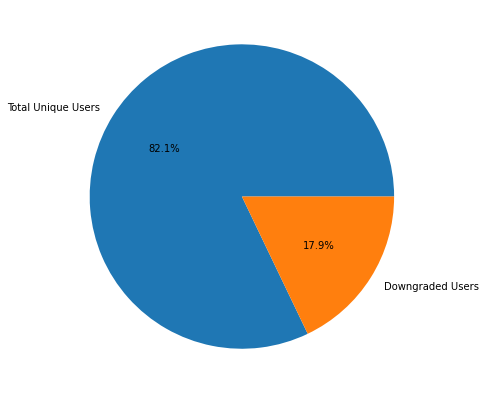

In [ ]:
data = [uni.userId.count(),down_uni.userId.count()]
label = ["Total Unique Users","Downgraded Users"]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = label,autopct='%1.1f%%')
  
# show plot
plt.show()

Let's look at a perticular user & observe it's behaviour

In [ ]:
usr_down.where(usr_down.userId == 131).show()

+------+---------+------+-----+----------------+-------------------+
|userId|firstName|gender|level|            page|            date_ts|
+------+---------+------+-----+----------------+-------------------+
|   131|     Kael|     M| paid|Submit Downgrade|2018-10-01 11:33:39|
|   131|     Kael|     M| paid|Submit Downgrade|2018-11-19 23:51:37|
+------+---------+------+-----+----------------+-------------------+



In [ ]:
df.filter("page == 'Upgrade'").select(["userId","firstName","gender","level","page","date_ts"]).where(df.userId == 131).show()

+------+---------+------+-----+-------+-------------------+
|userId|firstName|gender|level|   page|            date_ts|
+------+---------+------+-----+-------+-------------------+
|   131|     Kael|     M| free|Upgrade|2018-10-01 10:32:10|
+------+---------+------+-----+-------+-------------------+



Here we observe a perticular user(userID=131,kael) who downgraded their service twice on October & november month. later we try to find that when the user has upgraded their service so that we can have clear understanding. On the same day October 10th user upgraded the serive use for about an hour & then again submited downgrade.There should be one more submission of upgrade by the same user but it's not showing up, maybe beacause we filtered out some of missing & null values. let's move on to the next obervation.

In [ ]:
# Let's flag this downgrade serive as 0 or 1 with user define funciton.

downgrade_flag_func = udf(lambda x:1 if x == "Submit Downgrade" else 0, IntegerType())

In [ ]:
df = df.withColumn("downgraded", downgrade_flag_func("page"))

In [ ]:
df = df.withColumn('user_downgrade', Fmax('downgraded').over(Window.partitionBy('UserId')))

In [ ]:
df.select(["userId","firstName","gender","level","page","date_ts","downgraded","user_downgrade"]).where("downgraded == 1").show(10)

+------+---------+------+-----+----------------+-------------------+----------+--------------+
|userId|firstName|gender|level|            page|            date_ts|downgraded|user_downgrade|
+------+---------+------+-----+----------------+-------------------+----------+--------------+
|    54|    Alexi|     F| paid|Submit Downgrade|2018-10-15 12:54:20|         1|             1|
|    11|      Zoe|     F| paid|Submit Downgrade|2018-10-11 06:35:42|         1|             1|
|    30|    Colin|     M| paid|Submit Downgrade|2018-10-08 10:44:14|         1|             1|
|    59|   Jaleel|     M| paid|Submit Downgrade|2018-10-15 19:52:47|         1|             1|
|    85|  Brayden|     M| paid|Submit Downgrade|2018-10-12 09:13:19|         1|             1|
|    85|  Brayden|     M| paid|Submit Downgrade|2018-10-24 12:14:45|         1|             1|
|    35|     Lily|     F| paid|Submit Downgrade|2018-10-13 21:56:38|         1|             1|
|    35|     Lily|     F| paid|Submit Downgrade|20

Here, we can see that two columns are added now we can move towards the user who left our platform basically the churn users

In [ ]:
# we will start with creating a udf for churn user

churn_func = udf(lambda x:1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn_func("page"))
df = df.withColumn('churn_users', Fmax('churn').over(Window.partitionBy('UserId')))

In [ ]:
df.select(["userId","firstName","gender","level","page","date_ts","downgraded","user_downgrade","churn","churn_users"]).where("downgraded == 1").show(10)

+------+---------+------+-----+----------------+-------------------+----------+--------------+-----+-----------+
|userId|firstName|gender|level|            page|            date_ts|downgraded|user_downgrade|churn|churn_users|
+------+---------+------+-----+----------------+-------------------+----------+--------------+-----+-----------+
|    54|    Alexi|     F| paid|Submit Downgrade|2018-10-15 12:54:20|         1|             1|    0|          1|
|    11|      Zoe|     F| paid|Submit Downgrade|2018-10-11 06:35:42|         1|             1|    0|          0|
|    30|    Colin|     M| paid|Submit Downgrade|2018-10-08 10:44:14|         1|             1|    0|          0|
|    59|   Jaleel|     M| paid|Submit Downgrade|2018-10-15 19:52:47|         1|             1|    0|          0|
|    85|  Brayden|     M| paid|Submit Downgrade|2018-10-12 09:13:19|         1|             1|    0|          0|
|    85|  Brayden|     M| paid|Submit Downgrade|2018-10-24 12:14:45|         1|             1|  

#### Number of user who downgraded & cancle the service too

In [ ]:
df.where("user_downgrade == 1 and churn_users == 1").select(["userId","user_downgrade","churn_users"]).distinct().count()

9

we know that 49 users have downgraded & now out of that 9 unique users left our service or churn we can say

In [ ]:
# let's look by gender specific
churn_gender = df.drop_duplicates(['userId', 'gender']).groupby(['churn_users', 'gender']).count().toPandas()
churn_gender

,churn_users,gender,count
0,1,F,20
1,0,M,89
2,1,M,32
3,0,F,84


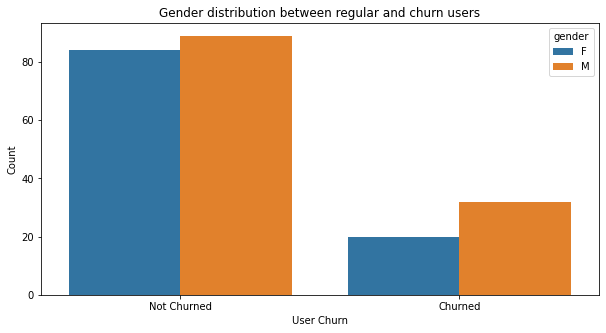

In [ ]:
# Let's Plot a bar graph to show gender distribution between regular and churn users
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Gender distribution between regular and churn users')
ax = sns.barplot(x = 'churn_users', y = 'count', data = churn_gender, hue = 'gender')

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn');

Let's find out something different we have lot of information in the page columns so let's with that.

#### Who made more friends? A churn user or a non_churn user

In [ ]:
friends_churn = df.select(["userId","page","churn_users"]).distinct().filter("page == 'Add Friend' and churn_users == 1").count()
friends_not_churn = df.select(["userId","page","churn_users"]).distinct().filter("page == 'Add Friend' and churn_users == 0").count()

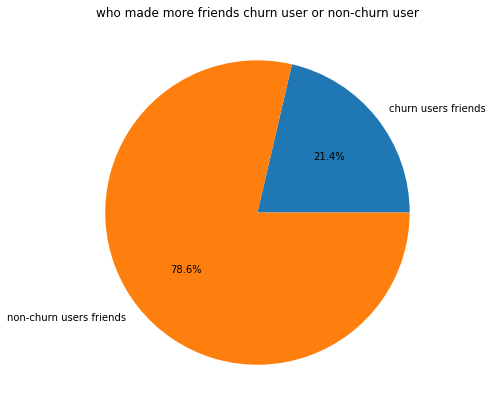

In [ ]:
# Plotting a pie graph of who made more friends churn user or non-churn user
fig = plt.figure(figsize =(10, 7))
data = [friends_churn,friends_not_churn]
label= ["churn users friends","non-churn users friends"]
plt.pie(data, labels = label,autopct='%1.1f%%')
plt.title("who made more friends churn user or non-churn user")
  
# show plot
plt.show()

#### Number of times the services has beed upgraded

In [ ]:
df.select("userId","page").filter("page == 'Upgrade'").count()

499

In [ ]:
thumsup_churn = df.select(["userId","page","churn_users"]).distinct().filter("page == 'Thumbs Up' and churn_users == 1").count()
thumsup_non_churn = df.select(["userId","page","churn_users"]).distinct().filter("page == 'Thumbs Up' and churn_users == 0").count()

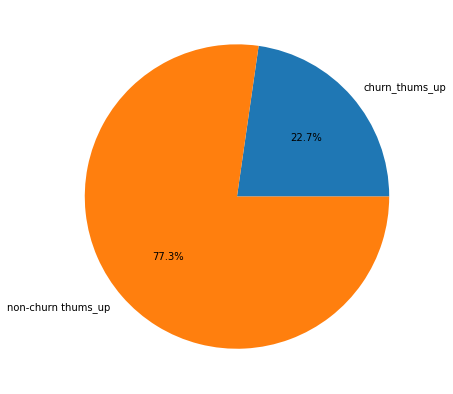

In [ ]:
# Plotting a pie graph of who liked more songs
fig = plt.figure(figsize =(10, 7))
data = [thumsup_churn,thumsup_non_churn]
label= ["churn_thums_up","non-churn thums_up"]
plt.pie(data, labels = label,autopct='%1.1f%%')
  
# show plot
plt.show()

## Feature Engineering 
let's make feature out of the data

we will do Feature Engineering, will extract some relevent features out the dataest which help us in building the model

Until now we have observed lot of things about the user, now that can be helpful here to make new features out of it. we will focus more on user's interection with our services that mean where the user has spend most of their time there we have to focus. Like that can pages, from this alone we can have lot of information about the interaction. so let's try building some features

what possible features can we get:

* User's Gender
* Paid or Free users
* User Downgraded
* total Number of songs listened by the user
* Number of thumbs up/down
* total time of user's service
* Number of songs played per session
* Number of songs added to playlist
* Music listened by the user at perticular hour
* Average Number of friends made by the user
* Number of times downgraded the service by the user in their service


In [ ]:
feature_df = [] # our list of features will go into this

#### User's gender

In [ ]:
def users_gender_func(df):
    """
    Makes user's gender column in 0's & 1's & adds in features. 1 for M & 0 for F
    :param df: Spark DataFrame
    :return None
    """
    
    gender_df = df.groupby('userId').agg(first(when(df['gender'] == "M", 1).otherwise(0)).alias('gender'))
    feature_df.append(gender_df)
    
    return None

users_gender_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int]]

#### Paid or Free users

we will create binary values for paid or free users

In [ ]:
def paid_free_users(df):
    """
    create binary values for paid or free users. 1 for paid & 0 for free
    :param df: Spark DataFrame
    :return None
    
    """
    
    level_df = df.groupby('userId').agg(first(when(df['level'] == "paid", 1).otherwise(0)).alias('level'))
    feature_df.append(level_df)
    
    return None

paid_free_users(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int], DataFrame[userId: string, level: int]]

####  Total songs listened by the user

In [ ]:
def total_songs_func(df):
    """
    creates a dataframe for total songs listened by the each user & add thid df to features
    :param df: Spark DataFrame
    :return None
    
    """
    
    total_songs_df = df.select("userId","page").filter("page == 'NextSong'").groupby("userId").count().withColumnRenamed("count","total_songs")
    feature_df.append(total_songs_df)
    
    return None

total_songs_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint]]

#### Number of thumbs up/down

In [ ]:
def thumbs_up_func(df):
    """
    creates a dataframe of thumbs up/down & it's count
    :param df: Spark DataFrame
    :return None
    
    """
    
    thumbs_up_df = df.select('userId', 'page').filter("page == 'Thumbs Up'").groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_up')
    feature_df.append(thumbs_up_df)
    
    return None

thumbs_up_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint],
 DataFrame[userId: string, thumbs_up: bigint]]

In [ ]:
def thumbs_down_func(df):
    """
    creates a dataframe of thumbs up/down & it's count
    :param df: Spark DataFrame
    :return None
    
    """
    
    thumbs_down_df = df.select('userId', 'page').filter("page == 'Thumbs Down'").groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_down')
    feature_df.append(thumbs_down_df)
    
    return None

thumbs_down_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint],
 DataFrame[userId: string, thumbs_up: bigint],
 DataFrame[userId: string, thumbs_down: bigint]]

#### Total time of user's service

In [ ]:
def users_service_time_func(df):
    """
    creates a dataframe of users life with our service using registration column
    :param df: Spark DataFrame
    :return None
    
    """
    
    users_service_time = df.groupby(['userId', 'ts', 'registration']).count() \
                            .withColumn('life_time', (df.ts - df.registration) / 1000) \
                            .groupBy('userId').agg(Fmax('life_time')).withColumnRenamed('max(life_time)', 'service_time')
    
    feature_df.append(users_service_time)
    
    return None

users_service_time_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint],
 DataFrame[userId: string, thumbs_up: bigint],
 DataFrame[userId: string, thumbs_down: bigint],
 DataFrame[userId: string, service_time: double]]

#### Number of songs played per session

In [ ]:
def songs_per_session_func(df):
    """
    creates a dataframe of Number of songs played in each session by the user.
    :param df: Spark DataFrame
    :return None
    
    """
    
    songs_per_session_df = df.filter(df.song.isNotNull()).groupby(['userId', 'sessionId']).count()\
                            .groupby(['userId']).count() \
                            .withColumnRenamed('count', 'songs_per_session')
    
    feature_df.append(songs_per_session_df)
    
    return None

songs_per_session_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint],
 DataFrame[userId: string, thumbs_up: bigint],
 DataFrame[userId: string, thumbs_down: bigint],
 DataFrame[userId: string, service_time: double],
 DataFrame[userId: string, songs_per_session: bigint]]

#### Average Number of friends made by the user

In [ ]:
def avg_noof_friedns_func(df):
    """
    creates a dataframe of average number of friends made by the user.
    :param df: Spark DataFrame
    :return None
    
    """
    
    avg_no_of_friends_df = df.filter('page == "Add Friend"').groupby(['userId']).count()\
                        .groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'avg_no_of_friends')
    
    feature_df.append(avg_no_of_friends_df)
    
    return None

avg_noof_friedns_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint],
 DataFrame[userId: string, thumbs_up: bigint],
 DataFrame[userId: string, thumbs_down: bigint],
 DataFrame[userId: string, service_time: double],
 DataFrame[userId: string, songs_per_session: bigint],
 DataFrame[userId: string, avg_no_of_friends: double]]

#### Number of times downgraded the service by the user in their service

In [ ]:
def downgrade_count_func(df):
    """
    creates a dataframe of number of time a user downgraded.
    :param df: Spark DataFrame
    :return None
    
    """
    
    downgrade_count_df = df.filter("page == 'Submit Downgrade'").select("userId").groupby("userId").count() \
                                .withColumnRenamed("count","downgrade_count")
    
    feature_df.append(downgrade_count_df)
    
    return None

downgrade_count_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint],
 DataFrame[userId: string, thumbs_up: bigint],
 DataFrame[userId: string, thumbs_down: bigint],
 DataFrame[userId: string, service_time: double],
 DataFrame[userId: string, songs_per_session: bigint],
 DataFrame[userId: string, avg_no_of_friends: double],
 DataFrame[userId: string, downgrade_count: bigint]]

#### Number of songs added to playlist

In [ ]:
def songs_added_to_playlist_func(df):
    """
    creates a dataframe of number of times a user added songs to playlist.
    :param df: Spark DataFrame
    :return None
    
    """
    
    songs_added_to_playlist_df = df.filter("page == 'Add to Playlist'").select('userID').groupBy('userID').count() \
                            .withColumnRenamed('count', 'songs_added_to_playlist')
    
    feature_df.append(songs_added_to_playlist_df)
    
    return None

songs_added_to_playlist_func(df)

In [ ]:
feature_df

[DataFrame[userId: string, gender: int],
 DataFrame[userId: string, level: int],
 DataFrame[userId: string, total_songs: bigint],
 DataFrame[userId: string, thumbs_up: bigint],
 DataFrame[userId: string, thumbs_down: bigint],
 DataFrame[userId: string, service_time: double],
 DataFrame[userId: string, songs_per_session: bigint],
 DataFrame[userId: string, avg_no_of_friends: double],
 DataFrame[userId: string, downgrade_count: bigint],
 DataFrame[userID: string, songs_added_to_playlist: bigint]]

In [ ]:
# Let's add downgraded & churn_users(target) column too our features_df

downgrade_df = df.select('userId', 'downgraded').distinct()
churn_df = df.select('userId', 'churn_users').distinct()

feature_df.append(downgrade_df)
feature_df.append(churn_df)

In [ ]:
len(feature_df) #length of the features we have including target

12

In [ ]:
#feature_df[0].join(feature_df[3], on=['userId'], how='left').show()

### Let's merge all df's we created into final df

In [ ]:
final_df = feature_df[0] #putting first df to make new dataframe variable

def merging_dataframes(final_df, remaining_df):
    '''  
    Merges all our dataframes into a final dataframe.
    
    :param first_df:  this is our final dataframe which will include all df's
    :param remaining_df:  these are our remaining df's which we created, will merge with final
    :return :         Returns a merged dataframe.
    
    '''
    
    merged_df = final_df.join(remaining_df, on=['userId'], how='left') # merges the df's
    
    return merged_df

for dfs in feature_df[1:]:
    final_df = merging_dataframes(final_df, dfs)

# fill nans if any
final_df = final_df.na.fill(0)
final_df.show(5)

+------+------+-----+-----------+---------+-----------+------------+-----------------+-----------------+---------------+-----------------------+----------+-----------+
|userId|gender|level|total_songs|thumbs_up|thumbs_down|service_time|songs_per_session|avg_no_of_friends|downgrade_count|songs_added_to_playlist|downgraded|churn_users|
+------+------+-----+-----------+---------+-----------+------------+-----------------+-----------------+---------------+-----------------------+----------+-----------+
|100010|     0|    0|        275|       17|          5|   4807612.0|                7|              4.0|              0|                      7|         0|          0|
|200002|     1|    0|        387|       21|          6|   6054448.0|                6|              4.0|              0|                      8|         0|          0|
|   125|     1|    0|          8|        0|          0|   6161779.0|                1|              0.0|              0|                      0|         0|     

In [ ]:
final_df.count()

274

In [ ]:
final_df.printSchema()  #schema of the final data

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- total_songs: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- service_time: double (nullable = false)
 |-- songs_per_session: long (nullable = true)
 |-- avg_no_of_friends: double (nullable = false)
 |-- downgrade_count: long (nullable = true)
 |-- songs_added_to_playlist: long (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- churn_users: integer (nullable = true)



## Prepare for Modeling

### Model Evaluation and Validation

We are all set to make our model now & will procede with further process.


In [ ]:
print(final_df.columns,end='')

['userId', 'gender', 'level', 'total_songs', 'thumbs_up', 'thumbs_down', 'service_time', 'songs_per_session', 'avg_no_of_friends', 'downgrade_count', 'songs_added_to_playlist', 'downgraded', 'churn_users']

In [ ]:
# we have two columns which type is string so we are casting it to interger type 
final_df = final_df.withColumn("userId", final_df.userId.cast(IntegerType()))
#final_df = final_df.withColumn("hours", final_df.hours.cast(IntegerType()))

In [ ]:
# Create VectorAssembler and StandardScaler objects
# numeric features transform separately from binary
num_vector = VectorAssembler(inputCols=['total_songs'
                                        , 'thumbs_up', 'thumbs_down', 'service_time', 'songs_per_session'
                                        , 'avg_no_of_friends', 'downgrade_count', 'songs_added_to_playlist'
                                        , 'downgraded'], 
                             outputCol='num_vector_assem')

num_scaler = StandardScaler(inputCol='num_vector_assem', outputCol ='num_vector_sc', withStd=True, withMean=True)

final_vector = VectorAssembler(inputCols=['level', 'gender']+['num_vector_sc'], 
                               outputCol='features_vector')

In [ ]:
# Transform data
data = num_vector.transform(final_df)

feature_standardize = num_scaler.fit(data)
data = feature_standardize.transform(data)

data = final_vector.transform(data)

In [ ]:
#final data
data = data.select(data.churn_users, data.features_vector)
data.show(5)

+-----------+--------------------+
|churn_users|     features_vector|
+-----------+--------------------+
|          0|[0.0,0.0,-0.70865...|
|          0|[0.0,1.0,-0.61796...|
|          1|[0.0,1.0,-0.92485...|
|          0|[1.0,0.0,2.371619...|
|          1|[1.0,1.0,0.778039...|
+-----------+--------------------+
only showing top 5 rows



In [ ]:
# Split Test and Train set
train, test = data.randomSplit([0.8, 0.2], seed=42)

### Baseline Model

In [ ]:
#baseline model
baseline = test.withColumn('prediction', lit(0.0))
baseline.show(5)

+-----------+--------------------+----------+
|churn_users|     features_vector|prediction|
+-----------+--------------------+----------+
|          0|[0.0,1.0,-0.61796...|       0.0|
|          0|[1.0,0.0,2.371619...|       0.0|
|          0|[1.0,1.0,0.618519...|       0.0|
|          1|[1.0,1.0,-0.75804...|       0.0|
|          0|[0.0,1.0,-0.88841...|       0.0|
+-----------+--------------------+----------+
only showing top 5 rows



## Evaluating Models

In [ ]:
def evaluate_model(model_result, model_name,start,end):
    """
    This function performs the evaluation of model.
    Task such as Predicting, finding accuracy, f1 score & total training time.
    :param model_lr_test: model.
    :param model_name: name of the model
    :param start: start time of the training
    :param end: end time of the training
    :return: returns the result of the model
    """

    print("\n")
    print("\n")
    print("Predicting Model...")

    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')  # Predicting model
    evaluator.setLabelCol('churn_users') #setting label column
    
    accuracy = evaluator.evaluate(model_result, {evaluator.metricName : 'accuracy'}) #getting accuracy
    f1 = evaluator.evaluate(model_result, {evaluator.metricName : 'f1'}) #getting f1 score
    time = (end - start)/60  # time of our model
    
    result = [model_name, round(accuracy,3), round(f1,3),round(time,1)] # saving the result

    return result

### Baseline model result

In [ ]:
#print baseline model
baseline_result = evaluate_model(baseline, 'Baseline', 0, 0)
print('{} performance metrics:'.format(baseline_result[0])) 
print('Accuracy: {}'.format(baseline_result[1]))            
print('F-1 Score: {}'.format(baseline_result[2]))
print("\n")





Predicting Model...
Baseline performance metrics:
Accuracy: 0.698
F-1 Score: 0.573




### Logistic Regression Model

In [ ]:
def build_logistic_regression_model():
    """
    This function performs building a logistic regression model, First it instantiate the model 
    second making the pipeline, setting the param grid, and finally putting all together in cross validator
    
    :return: Returns cv to fit the model
    """
    
    lr = LogisticRegression(maxIter=10, labelCol='churn_users', featuresCol='features_vector') #lr instantiate
    
    pipeline = Pipeline(stages=[lr])
    
    # this is parameters grid which we pass to a model.
    lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.1, 0.01, 0.001])
                .build())
    
    evaluator = MulticlassClassificationEvaluator(labelCol='churn_users')
    
    #an Estimator to produce a CrossValidatorModel
    cv = CrossValidator(estimator = pipeline, estimatorParamMaps = lr_paramGrid, evaluator=evaluator)

    return cv

### Random Forest Model

In [ ]:
def build_random_forest_model():
    """
    This function performs building a random forest model, First it instantiate the model 
    second making the pipeline, setting the param grid, and finally putting all together in cross validator
    
    :return: Returns cv to fit the model
    """
    
    numFolds = 3  # no of folds
    rf = RandomForestClassifier(labelCol='churn_users', featuresCol='features_vector', seed = 42) #rf classifier
    evaluator = MulticlassClassificationEvaluator(labelCol='churn_users') #multiclass evaluator 

    pipeline = Pipeline(stages=[rf])
    
    # this is parameters grid which we pass to a model.
    rf_paramGrid = (ParamGridBuilder()
                         .addGrid(rf.numTrees, [10,20])
                         .addGrid(rf.maxDepth, [10,20])
                         .build())
    
    # an Estimator to produce a CrossValidatorModel
    cv = CrossValidator(
                        estimator=pipeline
                        ,estimatorParamMaps=rf_paramGrid
                        ,evaluator=evaluator
                        ,numFolds=numFolds)

    return cv

### Gradient Boosting Model

In [ ]:
def build_gradient_boosting_model():
    """
    This function performs building a gradient boosting model, First it instantiate the model 
    second making the pipeline, setting the param grid, and finally putting all together in cross validator
    
    :return: Returns cv to fit the model
    """
    
    numFolds = 3    # no of folds
    gbt = GBTClassifier(labelCol='churn_users', featuresCol='features_vector', seed = 42) # gb classifier
    evaluator = MulticlassClassificationEvaluator(labelCol='churn_users')

    pipeline = Pipeline(stages=[gbt])  # pipeline which takes the stages
    
    # this is parameters grid which we pass to a model.
    gbt_paramGrid = (ParamGridBuilder()    
                         .addGrid(gbt.maxIter, [10,20])
                         .addGrid(gbt.maxDepth, [10,20])
                         .build())
    
    # an Estimator to produce a CrossValidatorModel
    cv = CrossValidator(
                    estimator=pipeline,
                    estimatorParamMaps=gbt_paramGrid,
                    evaluator=evaluator,
                    numFolds=numFolds)

    return cv

### Main function which drives all models do prediction, & display result

In [ ]:
def main(model):
    """
    This is main function which takes responsibility to build,train,predict & diplay result of the every model
    :param model: this takes the name of the model.
    :return: it return a result of the each model & if if pass wrong model name then returns a instruction.
    
    """
    
    
    if model == 'logistic_regression':
        print("\n")
        print('Building logistic_regression model')
        model_lr = build_logistic_regression_model()
        print("\n")
        print('Training model...')
        lr_start = time.time()
        model_fit = model_lr.fit(train)
        lr_end = time.time()
        print("\n")
        print('Training completed')
        print("\n")
        print('Evaluating model...')
        model_lr_preds = model_fit.transform(test) 
        model_result = evaluate_model(model_lr_preds, 'Logistic Regression',lr_start, lr_end)
        print('Evaluation completed')
        print("\n")
        print('Displaying result')
        display_result(model_result, model_fit)
        print("\n")
        print("Logistic Regression model completed")
        
        return model_result
            
    elif model == 'random_forest':
        print("\n")
        print("\n")
        print('Building random_forest model')
        model_rf = build_random_forest_model()
        print("\n")
        print('Training model...')
        rf_start = time.time()
        model_fit = model_rf.fit(train)
        rf_end = time.time()
        print("\n")
        print('Training completed')
        print("\n")
        print('Evaluating model...')
        model_rf_preds = model_fit.transform(test) 
        model_result = evaluate_model(model_rf_preds, 'Random Forest',rf_start, rf_end)
        print('Evaluation completed')
        print("\n")
        print('Displaying result')
        display_result(model_result, model_fit)
        print("\n")
        print("Random Forest model completed")
            
        return model_result
            
            
    elif model == 'gradient_boosting':
        print("\n")
        print("\n")
        print('Building gradient_boosting model')
        model_gb = build_gradient_boosting_model()
        print("\n")
        print('Training model...')
        gb_start = time.time()
        model_fit = model_gb.fit(train)
        gb_end = time.time()
        print("\n")
        print('Training completed')
        print("\n")
        print('Evaluating model...')
        model_gb_preds = model_fit.transform(test) 
        model_result = evaluate_model(model_gb_preds, 'gradient_boosting',gb_start, gb_end)
        print('Evaluation completed')
        print("\n")
        print('Displaying result')
        display_result(model_result, model_fit)
        print("\n")
        print("Gradient Boosting model completed")
            
        return model_result
    else:
        return "Please choose an appropriate model"
    

## Display Result

In [ ]:
def display_result(model_result, model_fit):
    """
        This function is responsible for displaying the result of the model.
        :param model_result: this param has predicted model
        :param model_fit: this param has trained model
    """
    print("\n")
    print('{} performance metrics:'.format(model_result[0])) 
    print("\n")
    print('Accuracy: {}'.format(model_result[1]))            
  
    print('F-1 Score: {}'.format(model_result[2]))
  
    print('Total training time: {} minutes'.format(model_result[3]))
  
    best_param = list(model_fit.getEstimatorParamMaps()[np.argmax(model_fit.avgMetrics)].values())
    print('Best regression parameter is {}'.format(best_param[0]))
    
    return None

In [ ]:
our_models = ['logistic_regression','random_forest','gradient_boosting']  #list of our models.

In [ ]:
final_model_result = [main(model) for model in our_models]  # runs each model & saves the result in variable.



Building logistic_regression model


Training model...


Training completed


Evaluating model...




Predicting Model...
Evaluation completed


Displaying result


Logistic Regression performance metrics:


Accuracy: 0.744
F-1 Score: 0.67
Total training time: 8.0 minutes
Total training time: 8.0 minutes
Best regression parameter is 0.01


Logistic Regression model completed




Building random_forest model


Training model...


Training completed


Evaluating model...




Predicting Model...
Evaluation completed


Displaying result


Random Forest performance metrics:


Accuracy: 0.837
F-1 Score: 0.824
Total training time: 13.2 minutes
Total training time: 13.2 minutes
Best regression parameter is 20


Random Forest model completed




Building gradient_boosting model


Training model...


Training completed


Evaluating model...




Predicting Model...
Evaluation completed


Displaying result


gradient_boosting performance metrics:


Accuracy: 0.814
F-1 Score: 0.814
Total training

## Justification & Conclusion

As we can see the result of the each model, it look lil promising to us about good prediction. let's discuss
each model separately starting with baseline model.

* Baseline Model: 

We created a prediction column of zeros which will help us to get an intuation anbout our target label. We can interpret things like what's our accuracy is going to be, or f1 score, we got a confidence about our approach that we can move further with the rest of the models.

* Logistic Regression: 

why we choose this as the first algorithm for our data? first of all we have to predict two classes 0's & 1's and we know things about logistic regression is that it is appropriate regression analysis to conduct when dependent variable is binary & it also is one step ahead and fitting the line values to the sigmoid curve. it was good start that we moved with this algorithm & saw it is predicting Accuracy: 0.744, F-1 Score: 0.67 which is above ok & indicated that we should try with some more advance algorithm.

* Random Forest:

Again why we choose that? for each & every algorithm we have to look into our data to choose a particular algorithm if we understood the data & target well then can make right choice for an algorithm. Talking about random forest, it builds multiple decision trees and merges them together to get a more accurate and stable prediction. but why to make multiple trees first in place? actully it tries to understand the dependecies in the data & according to it builds trees, it adds additional randomness to the model, while growing the trees. So we hoped that it will give the better result & that happened it gave us Accuracy: 0.837, F-1 Score: 0.824 & Total training time: 13.2 minutes which is arguingly good result. we are kind of satisfied with the result but also there is a room to increase the result. so, we tried one more algorithm let's discuss that.

* Gradient Boosting:

The reason for gradient boosting is that it is one of the most powerful techniques for building predictive models, & how's that possible? by otimizing the loss function, minimizing the overall prediction error & also many more steps goes behind that in gradient boosting, it improves the performance by reducing the overfitting which actually showed that it gave us the Accuracy: 0.814, F-1 Score: 0.814 Total training time: 73.0 minutes Best regression parameter is 10, what we observe fromt this is our accuracy reduced by .2% which is small but it did, & when we look at f1 score then it is almost similar to the accuracy which shows that it is correctly predicting the target label as per our f1 score. but negative side is that it is taking lot of time for training and predicting.

       

* #### Conclusion

My conclusion would be there are lot of things where we can go futher & can improve performance, Like we can explore more on the feature engineering part by creating more features such as pages, it has so manny columns that we did not consider it to be a feature, we can take some more features from that. for eg there is home page which user's visit not more like next song but user usually visit that page so it can be a lil contribution in our list, likewise there are pages like settings, help etc we can consider them as well if they are impacting our performance, we ploted a graph of pages which show's user's interaction we can take help of that.

Another area we can improve by having more informatio regarding music or songs we don't have much of data to explore on that side. From the log data we can make user of time & songs and create a feature out of it. So these are things from feature engineering we could improve.

We can go lil deep into how we can impute values by taking care of each of the columns & according to it how we can put correct values. we can keep track of null values of each column studying them after that putting values into that.

more ways can be explore at modeling level, by doing some more hyper parameter tuning or trying out with some other algorithm, or by changes at the scaling we can play lil bit in that area as well. So, these are my thought where we can improve our project. I found this project so interesting & fascinating cause I found some challenges, enjoyed creating new features & learned a lot new things with this.